In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [157]:
def grad_cos(x):
    x = x.clone()
    x.requires_grad_(True)
    
    f = torch.max(torch.abs(x))
    f.backward()
    return x.grad

In [158]:
grad_cos(torch.tensor([1.,2.,3.]))

tensor([0., 0., 1.])

In [159]:
import os
print(os.listdir("input"))

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'input'

In [160]:
os.chdir("input")


FileNotFoundError: [WinError 2] Не удается найти указанный файл: 'input'

In [161]:
os.listdir()

['resnet_data', 'seg_pred', 'seg_test', 'seg_train']

In [162]:
import torch
from torch import nn
from torchvision import datasets, models, transforms

In [163]:
data_path_format = '../input/seg_{0}'

In [164]:
np.random.seed(5315)
torch.manual_seed(9784)

In [165]:
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [166]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

In [167]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ../input/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )}


In [168]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [169]:
from sklearn import model_selection

In [170]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [171]:
import torch.utils.data as tdata

In [172]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [173]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ../input/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'train': <torch.utils.data.dataset.Subset object at 0x000001CA876B8820>, 'validation': <torch.utils.data.dataset.Subset object at 0x000001CA876B8100>}


In [174]:
from IPython.display import display

In [175]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [176]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [177]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

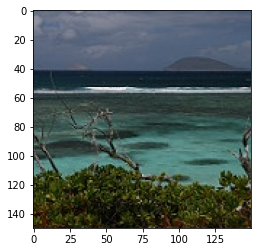

In [178]:
imshow(image_datasets['train'][8555][0])

In [179]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cpu_device

In [180]:
import torch.nn as nn

In [189]:
import torch.nn as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(50, 100, 5)
        self.relu1 = F.ReLU()
        self.conv3 = nn.Conv2d(100, 50, 10)
        self.relu5 = F.ReLU()
        self.conv4 = nn.Conv2d(50, 50, 5)
        self.relu6 = F.ReLU()
        self.fc1 = nn.Linear(50 * 56 * 56, 150)
        self.relu2 = F.ReLU()
        self.fc2 = nn.Linear(150, 84)
        self.relu3 = F.ReLU()
        self.fc3 = nn.Linear(84, 6)
        self.relu4 = F.ReLU()
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.relu1(self.conv2(x))
        x = self.relu5(self.conv3(x))
        x = self.relu6(self.conv4(x))
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        #x = x.view(16, -1, 6,  150)
        x = x.view(x.size(0), 50 * 56 * 56)
        x = self.relu2(self.fc1(x))
        x = self.relu3(self.fc2(x))
        x = self.relu4(self.fc3(x))
        return x

In [190]:
ptr = Net()
  
    
    
ptr = ptr.to(device)

In [191]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [192]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)

In [193]:
import time
start = time.time()

In [194]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(5, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.4093712009961092
Epoch 0, iteration 315 training_loss 1.1643797947636134
Epoch 0, iteration 473 training_loss 0.9913710106777239
Epoch 0, iteration 631 training_loss 0.9775049588348292
Epoch 0, iteration 789 training_loss 0.9072398409436021
Epoch 0, val_loss 0.8730871579186483, accuracy = 0.6581196581196581
Epoch 1, iteration 157 training_loss 0.8392818843639349
Epoch 1, iteration 315 training_loss 0.8204946734859974
Epoch 1, iteration 473 training_loss 0.7894881375228302
Epoch 1, iteration 631 training_loss 0.7637960888162444
Epoch 1, iteration 789 training_loss 0.7048009800005562
Epoch 1, val_loss 0.6907707986167886, accuracy = 0.7307692307692307
Epoch 2, iteration 157 training_loss 0.6402466415510147
Epoch 2, iteration 315 training_loss 0.6526294400608992
Epoch 2, iteration 473 training_loss 0.622458815574646
Epoch 2, iteration 631 training_loss 0.5837638882707946
Epoch 2, iteration 789 training_loss 0.5796457120700728
Epoch 2, val_loss 0.64488

In [195]:
end = time.time()
print(end - start)

19410.727292060852


In [196]:
from torchvision.utils import make_grid

In [197]:
xx, yy = next(iter(image_dataloaders['validation']))

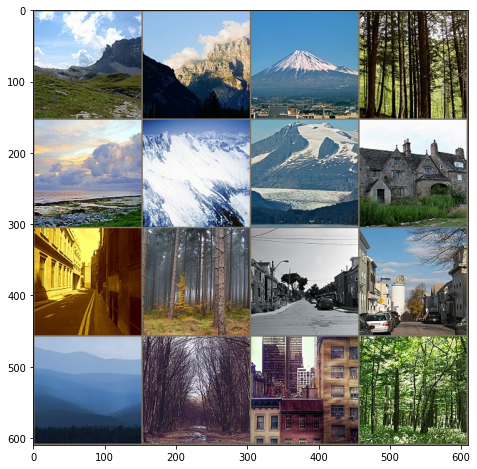

['mountain', 'mountain', 'mountain', 'forest', 'sea', 'glacier', 'glacier', 'buildings', 'street', 'forest', 'street', 'buildings', 'mountain', 'forest', 'street', 'forest']
['mountain', 'mountain', 'mountain', 'forest', 'sea', 'glacier', 'glacier', 'buildings', 'street', 'forest', 'street', 'street', 'mountain', 'forest', 'buildings', 'forest']


In [198]:
ptr.eval()
out = ptr(xx.cpu())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [199]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [200]:
from sklearn import metrics

In [201]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [202]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.82      0.67      0.73       437
      forest       0.93      0.94      0.94       474
     glacier       0.74      0.81      0.77       553
    mountain       0.81      0.70      0.76       525
         sea       0.77      0.82      0.80       510
      street       0.76      0.85      0.80       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [203]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,291,8,2,8,15,113
forest,4,445,2,5,2,16
glacier,3,4,447,43,51,5
mountain,5,2,104,370,42,2
sea,18,2,43,26,419,2
street,35,15,9,2,12,428
